Practical 1: Sentiment Detection in Movie Reviews
========================================



This practical concerns detecting sentiment in movie reviews. This is a typical NLP classification task.
In [this file](https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json) (80MB) you will find 1000 positive and 1000 negative **movie reviews**.
Each review is a **document** and consists of one or more sentences.

To prepare yourself for this practical, you should
have a look at a few of these texts to understand the difficulties of
the task: how might one go about classifying the texts? You will write
code that decides whether a movie review conveys positive or
negative sentiment.

Please make sure you have read the following paper:

>   Bo Pang, Lillian Lee, and Shivakumar Vaithyanathan
(2002). 
[Thumbs up? Sentiment Classification using Machine Learning
Techniques](https://dl.acm.org/citation.cfm?id=1118704). EMNLP.

Bo Pang et al. introduced the movie review sentiment
classification task, and the above paper was one of the first papers on
the topic. The first version of your sentiment classifier will do
something similar to Pang et al.'s system. If you have questions about it,
you should resolve you doubts as soon as possible with your TA.


**Advice**

Please read through the entire practical and familiarise
yourself with all requirements before you start coding or otherwise
solving the tasks. Writing clean and concise code can make the difference
between solving the assignment in a matter of hours, and taking days to
run all experiments.

## Environment

All code should be written in **Python 3**. 
This is the default in Google Colab.

In [1]:
!python --version

Python 3.7.11


If you want to run code on your own computer, then download this notebook through `File -> Download .ipynb`.
The easiest way to
install Python is through downloading
[Anaconda](https://www.anaconda.com/download). 
After installation, you can start the notebook by typing `jupyter notebook filename.ipynb`.
You can also use an IDE
such as [PyCharm](https://www.jetbrains.com/pycharm/download/) to make
coding and debugging easier. It is good practice to create a [virtual
environment](https://docs.python.org/3/tutorial/venv.html) for this
project, so that any Python packages don’t interfere with other
projects. 
 

**Learning Python 3**

If you are new to Python 3, you may want to check out a few of these resources:
- https://learnxinyminutes.com/docs/python3/
- https://www.learnpython.org/
- https://docs.python.org/3/tutorial/

In [2]:
import math
import copy
import os
import sys
from subprocess import call
from nltk import FreqDist
from nltk.util import ngrams
from nltk.stem.porter import PorterStemmer
import sklearn as sk
import pickle
import json
import typing as tg
from collections import Counter
import requests
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from scipy.sparse import csr_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
import pandas as pd
import seaborn as sns

In [3]:
# whether to check if GPY is enavled
CHECK_GPU = False

In [4]:
# checks
if CHECK_GPU:
  if not (int(os.environ["COLAB_GPU"]) > 0):
      raise ValueError("GPU Not enabled!")
try:
  import google.colab
  IN_COLAB = True
except ModuleNotFoundError:
  IN_COLAB = False
if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/drive/')
  os.chdir('/content/drive/MyDrive/Education/Masters/notebooks/nlp1/')

## Loading the data

**Download the sentiment lexicon and the movie reviews dataset.**

In [5]:
# download sentiment lexicon
!wget -nc https://gist.githubusercontent.com/bastings/d6f99dcb6c82231b94b013031356ba05/raw/f80a0281eba8621b122012c89c8b5e2200b39fd6/sent_lexicon
# download review data
!wget -nc https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json

File ‘sent_lexicon’ already there; not retrieving.

File ‘reviews.json’ already there; not retrieving.



**Load the movie reviews.**

Each word in a review comes with its part-of-speech tag. For documentation on POS-tags, see https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf.


In [6]:
# file structure:
# [
#  {"cv": integer, "sentiment": str, "content": list} 
#  {"cv": integer, "sentiment": str, "content": list} 
#   ..
# ]
# where `content` is a list of sentences, 
# with a sentence being a list of (token, pos_tag) pairs.

# true_sent = []

with open("reviews.json", mode="r", encoding="utf-8") as f:
  reviews = json.load(f)
  
print("Total number of reviews:", len(reviews), '\n')

def print_sentence_with_pos(s):
  print(" ".join("%s/%s" % (token, pos_tag) for token, pos_tag in s))

for i, r in enumerate(reviews):
  print(r["cv"], r["sentiment"], len(r["content"]))  # cv, sentiment, num sents
  # true_sent.append(r["sentiment"])
  print_sentence_with_pos(r["content"][0])
  if i == 4: 
    break
    
c = Counter()
for review in reviews:
  for sentence in review["content"]:
    for token, pos_tag in sentence:
      c[token.lower()] += 1
      
print("\nNumber of word types:", len(c))
print("Number of word tokens:", sum(c.values()))

print("\nMost common tokens:")
for token, count in c.most_common(20):
  print("%10s : %8d" % (token, count))
  

Total number of reviews: 2000 

0 NEG 29
Two/CD teen/JJ couples/NNS go/VBP to/TO a/DT church/NN party/NN ,/, drink/NN and/CC then/RB drive/NN ./.
1 NEG 11
Damn/JJ that/IN Y2K/CD bug/NN ./.
2 NEG 24
It/PRP is/VBZ movies/NNS like/IN these/DT that/WDT make/VBP a/DT jaded/JJ movie/NN viewer/NN thankful/JJ for/IN the/DT invention/NN of/IN the/DT Timex/NNP IndiGlo/NNP watch/NN ./.
3 NEG 19
QUEST/NN FOR/IN CAMELOT/NNP ``/`` Quest/NNP for/IN Camelot/NNP ''/'' is/VBZ Warner/NNP Bros./NNP '/POS first/JJ feature-length/JJ ,/, fully-animated/JJ attempt/NN to/TO steal/VB clout/NN from/IN Disney/NNP 's/POS cartoon/NN empire/NN ,/, but/CC the/DT mouse/NN has/VBZ no/DT reason/NN to/TO be/VB worried/VBN ./.
4 NEG 38
Synopsis/NNPS :/: A/DT mentally/RB unstable/JJ man/NN undergoing/VBG psychotherapy/NN saves/VBZ a/DT boy/NN from/IN a/DT potentially/RB fatal/JJ accident/NN and/CC then/RB falls/VBZ in/IN love/NN with/IN the/DT boy/NN 's/POS mother/NN ,/, a/DT fledgling/NN restauranteur/NN ./.

Number of wo

# Lexicon-based approach (3.5pts)



A traditional approach to classify documents according to their sentiment is the lexicon-based approach. To implement this approach, you need a **sentiment lexicon**, i.e., a list of words annotated with a sentiment label (e.g., positive and negative, or a score from 0 to 5).

In this practical, you will use the sentiment
lexicon released by Wilson et al. (2005).

> Theresa Wilson, Janyce Wiebe, and Paul Hoffmann
(2005). [Recognizing Contextual Polarity in Phrase-Level Sentiment
Analysis](http://www.aclweb.org/anthology/H/H05/H05-1044.pdf). HLT-EMNLP.

Pay attention to all the information available in the sentiment lexicon. The field *word1* contains the lemma, *priorpolarity* contains the sentiment label (positive, negative, both, or neutral), *type* gives you the magnitude of the word's sentiment (strong or weak), and *pos1* gives you the part-of-speech tag of the lemma. Some lemmas can have multiple part-of-speech tags and thus multiple entries in the lexicon. The path of the lexicon file is `"sent_lexicon"`.


In [7]:
pos = []
strengths = []
with open("sent_lexicon", mode="r", encoding="utf-8") as f:
    line_cnt = 0
    for line in f:
        metadata = line.strip()
        # print(metadata)
        w_type, w_len, word, word_pos, word_stem, polarity = metadata.split()
        pos.append(word_pos[5:])
        strengths.append(w_type[5:])
        line_cnt += 1
        # if line_cnt > 4:
        #     break

In [8]:
print(set(strengths))
print(set(pos))

{'weaksubj', 'strongsubj'}
{'verb', 'anypos', 'adj', 'adverb', 'noun'}


Lexica such as this can be used to solve
the classification task without using Machine Learning. For example, one might look up every word $w_1 ... w_n$ in a document, and compute a **binary score**
$S_{binary}$ by counting how many words have a positive or a
negative label in the sentiment lexicon $SLex$.

$$S_{binary}(w_1 w_2 ... w_n) = \sum_{i = 1}^{n}\text{sign}(SLex\big[w_i\big])$$

where $\text{sign}(SLex\big[w_i\big])$ refers to the polarity of $w_i$.

**Threshold.** On average, there are more positive than negative words per review (~7.13 more positive than negative per review) to take this bias into account you should use a threshold of **8** (roughly the bias itself) to make it harder to classify as positive.

$$
\text{classify}(S_{binary}(w_1 w_2 ... w_n)) = \bigg\{\begin{array}{ll}
        \text{positive} & \text{if } S_{binary}(w_1w_2...w_n) > threshold\\
        \text{negative} & \text{otherwise}
        \end{array}
$$


#### (Q1.1) Implement this approach and report its classification accuracy. (1 pt)

In [9]:
# YOUR CODE HERE
def compute_weighted_score(word_list: tg.List[str], lexicon: tg.Dict) -> int:
    """
    Computes the weighted score by summing the strength of each word in the
    word list

    Parameters
    ----------
    word_list : tg.List[str]
        The list of words to be scored.
    lexicon : tg.Dict
        The lexicon to be used for scoring
    Returns
    -------
    int
        The weighted score.
    """
    weighted_pol_arr = np.array(
        [
            lexicon[word]["strength"] * lexicon[word]["polarity"]
            for word in word_list
            if word in lexicon
        ]
    )
    return weighted_pol_arr.sum().astype(int)


def compute_bin_score(word_list: tg.List[str], lexicon: tg.Dict):
    """
    Computes the binary score by counting how many words have a positive or a
    negative label in the sentiment lexicon

    Parameters
    ----------
    word_list : tg.List[str]
        The list of words to be scored.
    lexicon : tg.Dict
        The lexicon to be used for scoring

    Returns
    -------
    int
        The binary score.
    """
    polarity_arr = np.array(
        [lexicon[word]["polarity"] for word in word_list if word in lexicon]
    )
    return polarity_arr.sum().astype(int)


def classify_document(
    document: tg.Dict,
    lexicon: tg.Dict,
    mode: str = "unweighted",
    thresh: float = 8.0,
    thresh_kind: str = "absolute",
) -> int:
    """
    Classifies a document using a lexicon approach as either positive or negative.

    Parameters
    ----------
    document : dict
        The document to be classified.
        {"cv": integer, "sentiment": str, "content": list of (word, pos)}
    lexicon : dict
        The lexicon to be used for scoring
    mode : str
        The mode of classification.
    thresh : float, default 8.0
        The threshold to be used for classification.
    thresh_kind : str, default "absolute"
        The kind of threshold to be used for classification.
        "absolute" for absolute threshold
        "density" for density threshold

    Returns
    -------
    int
        1 if the document is positive, -1 if negative.
    """
    assert mode in [
        "unweighted",
        "weighted",
    ], "`mode` must be either 'unweighted' or 'weighted'"
    # flatten document
    data = [
        word.lower()
        for sentence in document["content"]
        for word, _pos in sentence
        if word.lower() in lexicon and lexicon[word.lower()]["polarity"] in [1, -1]
    ]
    if mode == "unweighted":
        score_func = compute_bin_score
    else:
        score_func = compute_weighted_score
    score = score_func(data, lexicon)
    if thresh_kind == "density":
        thresh = np.ceil(thresh * len(data))
    # finally, we can classify
    return 1 if score > thresh else -1


def build_lexicon(file_path: str) -> tg.Dict:
    """
    Builds a lexicon from a file.

    Parameters
    -----------
    file_path : str The path to the file.

    Returns
    --------
    A dictionary containing the lexicon data
    """
    lexicon: tg.Dict = {}
    with open(file_path, "r") as f:
        # parse file line by line
        for line in f:
            strength, length, word, pos, stemmed, polarity = line.split()
            # we ignore duplicate words, keep only most recent
            lexicon[word[6:].lower()] = {
                "strength": 2 if strength[5:] == "strongsubj" else 1,
                "length": int(length[4:]),
                "pos": pos[5:],
                "stemmed": stemmed[9:],
                "polarity": 1
                if polarity[14:] == "positive"
                else -1
                if polarity[14:] == "negative"
                else 0,
            }
    return lexicon

In [10]:
# if name == main (lol)
lexicon = build_lexicon("sent_lexicon")
# pred and labels
y_pred = np.array([classify_document(review, lexicon) for review in reviews])
y_true = np.array([1 if review["sentiment"] == "POS" else -1 for review in reviews])

In [11]:
# token_results should be a list of binary indicators; for example [1, 0, 1, ...] 
# where 1 indicates a correct classification and 0 an incorrect classification.
token_results = (y_pred == y_true).astype(int)
token_accuracy = token_results.sum()/len(token_results)
print("Accuracy: %0.2f" % token_accuracy)

Accuracy: 0.68


As the sentiment lexicon also has information about the **magnitude** of
sentiment (e.g., *“excellent"* has the same sentiment _polarity_ as *“good"* but it has a higher magnitude), we can take a more fine-grained approach by adding up all
sentiment scores, and deciding the polarity of the movie review using
the sign of the weighted score $S_{weighted}$.

$$S_{weighted}(w_1w_2...w_n) = \sum_{i = 1}^{n}SLex\big[w_i\big]$$


Make sure you define an appropriate threshold for this approach.

#### (Q1.2) Now incorporate magnitude information and report the classification accuracy. Don't forget to use the threshold. (1pt)

In [12]:
# YOUR CODE HERE
def determine_threshold(
    documents: tg.List[tg.Dict],
    lexicon: tg.Dict,
    mode: str = "unweighted",
    kind: str = "absolute",
) -> float:
    """
    Determines the threshold to be used for classification, based on the
    average imbalance of positive to negative words in a document.

    Parameters
    ----------
    documents : tg.List[dict]
        The list of documents to be used for threshold determination.
    lexicon : dict
        The lexicon to be used for word polarity determination.
    mode : str, default "unweighted"
        The mode of classification.
    kind : str, default "absolute"
        The kind of threshold to be used for classification.
        "absolute" for absolute threshold
        "density" for density threshold
    """
    diffs = np.zeros(len(documents), dtype=float)
    lens = diffs.copy()
    for i, doc in enumerate(documents):
        n_positives = 0
        n_negatives = 0
        for sentence in doc["content"]:
            for word, _pos in sentence:
                word = word.lower()
                if word in lexicon:
                    lens[i] += 1
                    if mode == "unweighted":
                        weight = 1
                    else:
                        weight = lexicon[word]["strength"]
                    if lexicon[word]["polarity"] == 1:
                        n_positives += 1 * weight
                    elif lexicon[word]["polarity"] == -1:
                        n_negatives += 1 * weight
        diffs[i] = n_positives - n_negatives
    if kind == "density":
        return np.mean(diffs / lens)
    else:
        return np.ceil(np.mean(diffs))

In [13]:
new_thresh = determine_threshold(reviews, lexicon, "weighted")

y_pred = np.array(
    [classify_document(review, lexicon, "weighted", new_thresh) for review in reviews]
)
y_true = np.array([1 if review["sentiment"] == "POS" else -1 for review in reviews])

In [14]:
magnitude_results = (y_pred == y_true).astype(int)
magnitude_accuracy = magnitude_results.sum()/len(magnitude_results)
print("Accuracy: %0.2f" % magnitude_accuracy)

Accuracy: 0.70


#### (Q.1.4) Make a barplot of the two results (0.5pt)

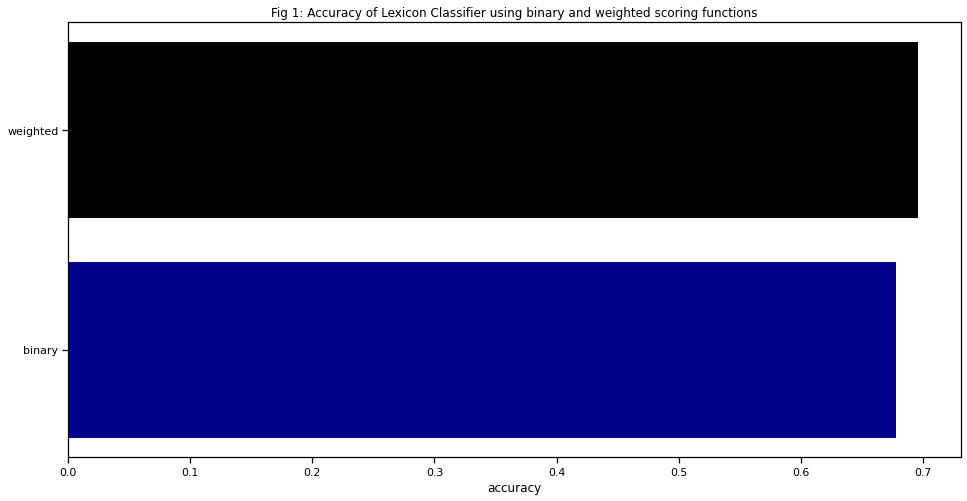

In [48]:
plt.figure(figsize=(16, 8))
plt.barh(
    ["binary", "weighted"],
    [token_accuracy, magnitude_accuracy],
    color=["darkblue", "black"],
)
plt.xlabel("accuracy")
plt.title("Fig 1: Accuracy of Lexicon Classifier using binary and weighted scoring functions")
plt.show()

#### (Q1.3) A better threshold (1pt)
Above we have defined a threshold to account for an inherent bias in the dataset: there are more positive than negative words per review.
However, that threshold does not take into account *document length*. Explain why this is a problem and implement an alternative way to compute the threshold.

---

Not taking into account document length is problematic because unfairly punishes shorter documents. For an instance, a very short positive review with less positive words than the threshold will be incorrectly classified as negative. A simple solution to this is computing the threshold dynamically for each document based on its length. This could consist in dividing the original threshold by the average number of words per document, hence obtaining a threshold density. We could then obtain the dynamic threshold for a given document by multiplying the threshold density by the number of words in the given document.

The code below shows what arguments to pass to the functions defined in previous cells to enable such an implementation, using weighted polarity.

---

In [16]:
# YOUR CODE HERE
new_thresh = determine_threshold(reviews, lexicon, "weighted", "density")

y_pred = np.array(
    [
        classify_document(review, lexicon, "weighted", new_thresh, "density")
        for review in reviews
    ]
)
y_true = np.array([1 if review["sentiment"] == "POS" else -1 for review in reviews])

# check results
better_results = (y_pred == y_true).astype(int)
better_accuracy = better_results.sum()/len(better_results)
print("Accuracy: %0.2f" % better_accuracy)

Accuracy: 0.68


# Naive Bayes (9.5pts)


Your second task is to program a simple Machine Learning approach that operates
on a simple Bag-of-Words (BoW) representation of the text data, as
described by Pang et al. (2002). In this approach, the only features we
will consider are the words in the text themselves, without bringing in
external sources of information. The BoW model is a popular way of
representing texts as vectors, making it
easy to apply classical Machine Learning algorithms on NLP tasks.
However, the BoW representation is also very crude, since it discards
all information related to word order and grammatical structure in the
original text—as the name suggests.

## Writing your own classifier (4pts)

Write your own code to implement the Naive Bayes (NB) classifier. As
a reminder, the Naive Bayes classifier works according to the following
equation:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} P(c|\bar{f}) = \operatorname*{arg\,max}_{c \in C} P(c)\prod^n_{i=1} P(f_i|c)$$
where $C = \{ \text{POS}, \text{NEG} \}$ is the set of possible classes,
$\hat{c} \in C$ is the most probable class, and $\bar{f}$ is the feature
vector. Remember that we use the log of these probabilities when making
a prediction:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} \Big\{\log P(c) + \sum^n_{i=1} \log P(f_i|c)\Big\}$$

You can find more details about Naive Bayes in [Jurafsky &
Martin](https://web.stanford.edu/~jurafsky/slp3/). You can also look at
this helpful
[pseudo-code](https://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html).

*Note: this section and the next aim to put you in a position to replicate
    Pang et al.'s Naive Bayes results. However, your numerical results
    will differ from theirs, as they used different data.*

**You must write the Naive Bayes training and prediction code from
scratch.** You will not be given credit for using off-the-shelf Machine
Learning libraries.

The data contains the text of the reviews, where each document consists
of the sentences in the review, the sentiment of the review and an index
(cv) that you will later use for cross-validation. The
text has already been tokenised and POS-tagged for you. Your algorithm
should read in the text, **lowercase it**, store the words and their
frequencies in an appropriate data structure that allows for easy
computation of the probabilities used in the Naive Bayes algorithm, and
then make predictions for new instances.


#### (Q2.1) Unseen words (1pt)
The presence of words in the test dataset that
have not been seen during training can cause probabilities in the Naive Bayes classifier to equal $0$.
These can be words which are unseen in both positive and negative training reviews (case 1), but also words which are seen in reviews _of only one sentiment class_ in the training dataset (case 2). In both cases, **you should skip these words for both classes**.  What would be the problem instead with skipping words only for one class in case 2? 

---

To compute the score (log posterior), we need the per-class log-prior and per-word-in-class log-likelihood. The latter is computed as the log of the count of the given word for that class over the total count of words in that class. If a given word in the vocabulary did not appear when training a specific class, the count for that word in that class will be 0. This results in an estimated likelihood of 0 for that word, which is unreasonable. More importantly howveer, this makes it impossible to find the log likelihood for that word, since the log of 0 is undefined. The problem traverses upwards in our implementation causing our estimated score to be incorrect. This is why our vocabulary needs to consist in words that appear across both classes at least once in the training when we are not smoothing.

---

#### (Q2.2) Train your classifier on (positive and negative) reviews with cv-value 000-899, and test it on the remaining (positive and negative) reviews cv900–cv999.  Report results using classification accuracy as your evaluation metric. Your  features are the word vocabulary. The value of a feature is the count of that feature (word) in the document. (2pts)


In [17]:

SENT_MAP = {
    "POS": 0,
    "NEG": 1,
}


def preprocess_reviews(
    reviews: tg.List[tg.Dict],
    stem: bool = False,
    bigrams: bool = False,
    trigrams: bool = False,
    cached: bool = False,
) -> tg.List[tg.Dict]:
    """
    Preprocesses the reviews with lower-casing or stemming
    and/or bigram and trigram calculation

    Parameters
    ----------
    reviews : tg.List[Dict]
        the reviews to preprocess
    stem : bool, default False
        Whether to stem the reviews, if False, simply lower-cases
    bigram : bool, default False
        Whether to calculate bigrams
    trigrams : bool, default False
        Whether to calculate bigrams _and_ trigrams
    cached : bool, default False
        Whether the passed `reviews` are already lower-cased/stemmed

    Returns
    -------
    tg.List[Dict]
        the preprocessed reviews
    """
    if not cached:
        if stem:
            print("Stemming requested; stemming...")
            stemmer = PorterStemmer()
            new_reviews = [
                {
                    "cv": review["cv"],
                    "sentiment": review["sentiment"],
                    "content": [
                        [(stemmer.stem(word), pos) for word, pos in sentence]
                        for sentence in review["content"]
                    ],
                }
                for review in reviews
            ]
            print("Stemming complete.")
        else:
            new_reviews = [
                {
                    "cv": review["cv"],
                    "sentiment": review["sentiment"],
                    "content": [
                        [(word.lower(), pos) for word, pos in sentence]
                        for sentence in review["content"]
                    ],
                }
                for review in reviews
            ]
    else:
        new_reviews = copy.deepcopy(reviews)
    if bigrams or trigrams:
        print("Computing ngrams...")
        for review in new_reviews:
            review_words = [
                word for sentence in review["content"] for word, _pos in sentence
            ]
            review_bigrams = list(ngrams(review_words, 2))
            bigram_pos = ["bigram" for bigram in review_bigrams]
            review["content"].append(list(zip(review_bigrams, bigram_pos)))
            if trigrams:
                review_trigrams = list(ngrams(review_words, 3))
                trigram_pos = ["trigram" for trigram in review_trigrams]
                review["content"].append(list(zip(review_trigrams, trigram_pos)))
        print("Done.")
    return new_reviews


def extract_vocab(
    documents: tg.List[tg.Dict], use_pos: bool = False, only_open: bool = False
):
    """
    Extracts the vocabulary from the documents,

    Parameters
    ----------
    documents : tg.List[Dict]
    use_pos : bool, default False
        Whether to use the word+POS as vocab keys
    only_open : bool, default False
        Whether to only include open-class POS-tagged words,
        ignored if `use_pos` is False

    Returns
    -------
    dict
        The vocabulary
    """
    vocab = {}
    for doc in documents:
        for sentence in doc["content"]:
            for token, pos in sentence:
                if use_pos:
                    key = (token, pos)
                    if only_open:
                        if pos not in POS_MAP:
                            # skip this token
                            continue
                else:
                    key = token
                if key not in vocab:
                    vocab[key] = {"POS": 0, "NEG": 0}
                if doc["sentiment"] == "POS":
                    vocab[key]["POS"] += 1
                elif doc["sentiment"] == "NEG":
                    vocab[key]["NEG"] += 1
    return vocab




def train_nb(
    classes: tg.Tuple[str, ...],
    documents: tg.List[tg.Dict],
    alpha: float = 0,
):
    """
    Trains a Naive Bayes model
    Parameters
    ----------
    classes : tg.Tuple[str, ...]
        the classes that the model should predict
    documents : tg.List[Dict]
        the documents on which to train on
    alpha : float
        smoothing parameter, which is added to word counts.

    Returns
    -------
    vocab : tg.Dict
        the computed vocabulary for the input documents
    logprior : npt.NDArray
        (n_classes, ) array of log priors
    loglikelihood : tg.List[tg.Dict]
        (n_classes, ) array of dictionary containing loglikelihood of each word
    """
    vocab: tg.Dict = extract_vocab(documents)
    if alpha == 0:
        # filter vocab if we are not applying smoothing
        vocab = {k: v for (k, v) in vocab.items() if v["POS"] > 0 and v["NEG"] > 0}

    n_docs = len(documents)
    logprior = np.zeros(len(classes))
    loglikelihood: tg.List[tg.Dict] = [{} for _ in range(len(classes))]
    for c, clx in enumerate(classes):
        clx_docs = [doc for doc in documents if doc["sentiment"] == clx]
        n_docs_clx = len(clx_docs)
        logprior[c] = np.log(n_docs_clx / n_docs)
        # compute sum of word counts, which we'll use to compute loglikelihood (denom)
        word_counts_sum = (np.array([vocab[word][clx] for word in vocab]) + alpha).sum()
        for word in vocab:
            loglikelihood[c][word] = np.log(
                (vocab[word][clx] + alpha) / (word_counts_sum)
            )
    return vocab, logprior, loglikelihood


def nb_predict(
    classes: tg.Tuple[str, ...],
    vocab: tg.Dict,
    logprior: npt.NDArray[float],
    loglikelihood: tg.List[tg.Dict],
    doc: tg.Dict,
):
    """
    Predicts the sentiment of a document

    Parameters
    ----------
    classes : tg.Tuple[str, ...]
    vocab : tg.Dict
    prior : npt.NDArray
    loglikelihood : tg.List[tg.Dict]
    doc : tg.Dict
        the document to classify

    Returns
    -------
    int
        The index of the predicted class
    """
    doc_text = [
        token
        for sentence in doc["content"]
        for token, _pos in sentence
        if token in vocab
    ]
    score: npt.NDArray = np.zeros(len(classes), dtype=float)
    for c, clx in enumerate(classes):
        score[c] = logprior[c]
        for token in doc_text:
            if token in vocab:
                score[c] += loglikelihood[c][token]

    return np.argmax(score)


def train_eval_nb(
    train_data: tg.List[tg.Dict], test_data: tg.List[tg.Dict], alpha: float = 0
) -> tg.Tuple[float, float, float, float]:
    """
    Trains and evaluates a Naive Bayes model

    Parameters
    ----------
    train_data : tg.List[Dict]
        the training data
    test_data : tg.List[Dict]
    alpha : float, default 0
        smoothing parameter, which is added to word counts.

    Returns
    -------
    metrics : tuple of floats
        tuple of accuracy, precision, recall and vocab size
    """
    vocab, logprior, loglikelihood = train_nb(("POS", "NEG"), train_data, alpha)
    y_pred = np.array(
        [
            nb_predict(("POS", "NEG"), vocab, logprior, loglikelihood, doc)
            for doc in test_data
        ]
    )
    y_true = np.array([SENT_MAP[doc["sentiment"]] for doc in test_data])

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    vocab_size = len(vocab.keys())

    return accuracy, precision, recall, vocab_size



In [18]:
lower_case_reviews = preprocess_reviews(reviews)

train_idxs = range(0, 900)
test_idxs = range(900, 1000)
train_reviews = [review for review in lower_case_reviews if review["cv"] in train_idxs]
test_reviews = [review for review in lower_case_reviews if review["cv"] in test_idxs]


accuracy, precision, recall, vocab_size = train_eval_nb(train_reviews, test_reviews)

print(f"Accuracy: {accuracy:.3f}")

Accuracy: 0.835


#### (Q2.3) Would you consider accuracy to also be a good way to evaluate your classifier in a situation where 90% of your data instances are of positive movie reviews? (1pt)

Simulate this scenario by keeping the positive reviews
data unchanged, but only using negative reviews cv000–cv089 for
training, and cv900–cv909 for testing. Calculate the classification
accuracy, and explain what changed.

---

I would not consider accuracy to be a good way to evaluate our classifier in this situation. This is because in such a case, our dataset is strongly unbalanced towards one class, the positive one. The result is that our model will be incorrectly biased (and in a sense rewarded) for simply learning to predict the majority class regardless of the input. In a way, it is overfitting to a certain class. Because the majority of the input will be of this class, most of the model's predictions will be correct, increasing accuracy and artificially obtaining "good" results. While this may be fine for a problem where false positives are not a concern, it becomes problematic in problems sensitive to type I errors. This is noticed below where our accuracy increases when using an unbalanced dataset. Other metrics, such as precision and recall, are better suited for classification problems.

---

In [19]:
# YOUR CODE HERE
def split_data(
    data: tg.List[tg.Dict],
    pos_start_stop: tg.Tuple[tg.Tuple[int, int], tg.Tuple[int, int]],
    neg_start_stop: tg.Optional[
        tg.Tuple[tg.Tuple[int, int], tg.Tuple[int, int]]
    ] = None,
) -> tg.Tuple[tg.List[tg.Dict], tg.List[tg.Dict]]:
    """
    Splits data into training and testing sets,
    allowing for different starts and stops between
    negative and positive classes

    Parameters
    ----------
    data : tg.List[Dict]
        the data to split
    pos_start_stop : tg.Tuple[tg.Tuple[int, int], tg.Tuple[int, int]]
        ((train_start, train_stop), (test_start, test_stop))
        for positive class
    neg_start_stop : tg.Tuple[tg.Tuple[int, int], tg.Tuple[int, int]]
        ((train_start, train_stop), (test_start, test_stop))
        for negative class. Optional, if None, will use the same as positive

    Returns
    -------
    tg.Tuple[tg.List[Dict], tg.List[Dict]]
        (train_data, test_data)
    """
    if neg_start_stop is None:
        neg_start_stop = pos_start_stop
    starts_stops = (pos_start_stop, neg_start_stop)
    train = []
    test = []
    for i, clx in enumerate(("POS", "NEG")):
        print(
            f"Splitting data for class {clx} \n"
            f"Using train indices {starts_stops[i][0]} and "
            f"test indices {starts_stops[i][1]}"
        )

        train_idxs = range(starts_stops[i][0][0], starts_stops[i][0][1])
        test_idxs = range(starts_stops[i][1][0], starts_stops[i][1][1])
        train_data = [
            data_entry
            for data_entry in data
            if data_entry["cv"] in train_idxs and data_entry["sentiment"] == clx
        ]
        train += train_data

        test_data = [
            data_entry
            for data_entry in data
            if data_entry["cv"] in test_idxs and data_entry["sentiment"] == clx
        ]
        test += test_data
    return train, test

In [20]:
pos_idxs = (0, 900, 900, 1000)
neg_idxs = (0, 90, 900, 910)

train_reviews, test_reviews = split_data(
        lower_case_reviews,
        (pos_idxs[:2], pos_idxs[2:]),
        (neg_idxs[:2], neg_idxs[2:]),
)

accuracy, precision, recall, vocab_size = train_eval_nb(train_reviews, test_reviews)

print(f"Accuracy: {accuracy:.3f}")

Splitting data for class POS 
Using train indices (0, 900) and test indices (900, 1000)
Splitting data for class NEG 
Using train indices (0, 90) and test indices (900, 910)
Accuracy: 0.891


## Smoothing (1pt)

As mentioned above, the presence of words in the test dataset that
have not been seen during training can cause probabilities in the Naive
Bayes classifier to be $0$, thus making that particular test instance
undecidable. The standard way to mitigate this effect (as well as to
give more clout to rare words) is to use smoothing, in which the
probability fraction
$$\frac{\text{count}(w_i, c)}{\sum\limits_{w\in V} \text{count}(w, c)}$$ for a word
$w_i$ becomes
$$\frac{\text{count}(w_i, c) + \text{smoothing}(w_i)}{\sum\limits_{w\in V} \text{count}(w, c) + \sum\limits_{w \in V} \text{smoothing}(w)}$$





#### (Q2.4) Implement Laplace feature smoothing (1pt)
Implement Laplace smoothing, i.e., smoothing with a constant value ($smoothing(w) = \kappa, \forall w \in V$), in your Naive
Bayes classifier’s code, and report the impact on performance. 
Use $\kappa = 1$.

In [21]:
# YOUR CODE HERE
# Laplace smoothing is already available in our implementation above, we just
# need to pass an argument of alpha=1 when training:
train_reviews, test_reviews = split_data(
    lower_case_reviews,
    (pos_idxs[:2], pos_idxs[2:]),
)
accuracy, precision, recall, vocab_size = train_eval_nb(train_reviews, test_reviews, 1)

print(f"Accuracy: {accuracy:.3f}")

Splitting data for class POS 
Using train indices (0, 900) and test indices (900, 1000)
Splitting data for class NEG 
Using train indices (0, 900) and test indices (900, 1000)
Accuracy: 0.825


## Cross-Validation (1.5pts)

A serious danger in using Machine Learning on small datasets, with many
iterations of slightly different versions of the algorithms, is ending up with Type III errors, also called the “testing hypotheses
suggested by the data” errors. This type of error occurs when we make
repeated improvements to our classifiers by playing with features and
their processing, but we don’t get a fresh, never-before seen test
dataset every time. Thus, we risk developing a classifier that gets better
and better on our data, but only gets worse at generalizing to new, unseen data. In other words, we risk developping a classifier that overfits.

A simple method to guard against Type III errors is to use
Cross-Validation. In **N-fold Cross-Validation**, we divide the data into N
distinct chunks, or folds. Then, we repeat the experiment N times: each
time holding out one of the folds for testing, training our classifier
on the remaining N - 1 data folds, and reporting performance on the
held-out fold. We can use different strategies for dividing the data:

-   Consecutive splitting:
  - cv000–cv099 = Split 1
  - cv100–cv199 = Split 2
  - etc.
  
-   Round-robin splitting (mod 10):
  - cv000, cv010, cv020, … = Split 1
  - cv001, cv011, cv021, … = Split 2
  - etc.

-   Random sampling/splitting
  - Not used here (but you may choose to split this way in a non-educational situation)



#### (Q2.5) Write the code to implement 10-fold cross-validation using round-robin splitting for your Naive Bayes classifier from Q2.4 and compute the 10 accuracies. Report the final performance, which is the average of the performances per fold. If all splits perform equally well, this is a good sign. (1pt)

In [22]:
def rr_cv_split(
    data_len: int,
    n_splits: int,
    modulo: int,
    alpha: float = 0,
) -> tg.Tuple[npt.NDArray, npt.NDArray]:
    """
    Performs round robin cross validation split

    Parameters
    ----------
    data_len : int
        the length of the data
    n_splits : int
        the number of splits
    modulo : int
        the modulo to use for round robin splitting
    alpha : float, default 0
        the smoothing parameter, which is added to word counts

    Returns
    -------
    tuple of ndarray
        tuple containing two (n_splits, -1) ndarrays
        the first containing the indices of the training splits
        and the second containing the indices of the test splits
    """

    base_split: npt.NDArray = np.arange(0, (data_len - n_splits) + 1, modulo)
    splits: tg.List[npt.NDArray] = [base_split + i for i in range(n_splits)]

    train_splits = np.zeros((n_splits, len(base_split) * (n_splits - 1)))
    test_splits = np.zeros((n_splits, len(base_split)))

    for i, test_data_idxs in enumerate(splits):
        train_splits[i] = np.concatenate(splits[:i] + splits[(i + 1) :])  # noqa:E203
        test_splits[i] = test_data_idxs

    return train_splits, test_splits

def perform_rr_cv_nb(
    data: tg.List[tg.Dict],
    n_splits: int,
    modulo: int,
    alpha: float = 0,
    data_len: tg.Optional[int] = None,
    verbose: bool = True
):
    """
    Performs round robin cross validation of a naive bayes model

    Parameters
    ----------
    data : tg.List[tg.Dict]
        the data to use for training and testing
    n_splits : int
        the number of splits to perform
    modulo : int
        the modulo to use for round robin splitting
    alpha : float, default 0
        smoothing parameter, which is added to word counts.
    data_len : int, default None
        The length of the data to split. If not provided
        is inferred from the data
    verbose: bool, default True
        Whether to print diagnostics

    Returns
    -------
    metrics : npt.NDArray
        (4, n_splits) array of accuracies, precisions, recalls and vocab sizes
    """
    if data_len is None:
        data_len = len(data)

    train, test = rr_cv_split(data_len, n_splits, modulo)

    metrics = np.zeros((4, n_splits), dtype=float)

    for i, (train_idxs, test_idxs) in enumerate(zip(train, test)):
        if verbose:
            print(f"Cross validating on split {i+1} of {n_splits}")

        train_data = [
            data_entry for data_entry in data if data_entry["cv"] in train_idxs
        ]
        test_data = [data_entry for data_entry in data if data_entry["cv"] in test_idxs]

        metrics[:, i] = train_eval_nb(train_data, test_data, alpha)

    if verbose:
        print("Cross validation complete.")

    return metrics



In [23]:
smooth_metrics = perform_rr_cv_nb(lower_case_reviews, 10, 10, 1, 1000)

Cross validating on split 1 of 10
Cross validating on split 2 of 10
Cross validating on split 3 of 10
Cross validating on split 4 of 10
Cross validating on split 5 of 10
Cross validating on split 6 of 10
Cross validating on split 7 of 10
Cross validating on split 8 of 10
Cross validating on split 9 of 10
Cross validating on split 10 of 10
Cross validation complete.


In [24]:
print(f"\nCV accuracies: {smooth_metrics[0]}")
print(f"mean CV accuracy: {smooth_metrics[0].mean():.3f}")


CV accuracies: [0.79  0.835 0.805 0.825 0.78  0.845 0.83  0.775 0.83  0.84 ]
mean CV accuracy: 0.815


#### (Q2.6) Report the variance of the 10 accuracy scores. (0.5pt)

**Please report all future results using 10-fold cross-validation now
(unless told to use the held-out test set).**

In [25]:
# YOUR CODE HERE
print(f"CV accuracy variance: {smooth_metrics[0].var():.6f}")

CV accuracy variance: 0.000602


## Features, overfitting, and the curse of dimensionality

In the Bag-of-Words model, ideally we would like each distinct word in
the text to be mapped to its own dimension in the output vector
representation. However, real world text is messy, and we need to decide
on what we consider to be a word. For example, is “`word`" different
from “`Word`", from “`word`”, or from “`words`"? Too strict a
definition, and the number of features explodes, while our algorithm
fails to learn anything generalisable. Too lax, and we risk destroying
our learning signal. In the following section, you will learn about
confronting the feature sparsity and the overfitting problems as they
occur in NLP classification tasks.

### Stemming (1.5pts)

To make your algorithm more robust, use stemming and hash different inflections of a word to the same feature in the BoW vector space. Please use the [Porter stemming
    algorithm](http://www.nltk.org/howto/stem.html) from NLTK.



In [26]:
# YOUR CODE HERE
stemmed_reviews = preprocess_reviews(reviews, True)

Stemming requested; stemming...
Stemming complete.


#### (Q2.7): How does the performance of your classifier change when you use stemming on your training and test datasets? (1pt)
Use cross-validation to evaluate the classifier. 


In [27]:
stem_metrics = perform_rr_cv_nb(stemmed_reviews, 10, 10, 1, 1000)

Cross validating on split 1 of 10
Cross validating on split 2 of 10
Cross validating on split 3 of 10
Cross validating on split 4 of 10
Cross validating on split 5 of 10
Cross validating on split 6 of 10
Cross validating on split 7 of 10
Cross validating on split 8 of 10
Cross validating on split 9 of 10
Cross validating on split 10 of 10
Cross validation complete.


In [28]:
print(f"CV accuracies: {stem_metrics[0]}")
print(f"mean CV accuracy: {stem_metrics[0].mean():.3f}")
print(f"CV accuracy variance: {stem_metrics[0].var():.6f}")

CV accuracies: [0.785 0.84  0.805 0.835 0.77  0.845 0.82  0.775 0.825 0.83 ]
mean CV accuracy: 0.813
CV accuracy variance: 0.000686


The accuracy decreases when using stemming, while the variance increases. Both these changes are marginal and potentially negligible with respect to the values obtained in 2.5.

#### (Q2.8) What happens to the number of features (i.e., the size of the vocabulary) when using stemming as opposed to (Q2.4)? (0.5pt)
Give actual numbers. You can use the held-out training set to determine these.

In [29]:
mean_vocab_size = smooth_metrics[-1].mean()
mean_stem_vocab_size = stem_metrics[-1].mean()
percentage_change = (
    (-1 if mean_stem_vocab_size < mean_vocab_size else 1)
    * np.abs(mean_vocab_size - mean_stem_vocab_size)
    / mean_vocab_size
) * 100


print(f"Average vocab size without stemming: {mean_vocab_size:.2f}")
print(f"Average vocab size with stemming: {mean_stem_vocab_size:.2f}")
print(f"percentage change: {percentage_change:.2f} %")

Average vocab size without stemming: 45446.50
Average vocab size with stemming: 32680.20
percentage change: -28.09 %


The number of features decreases when using stemming

### N-grams (1.5pts)

A simple way of retaining some of the word
order information when using bag-of-words representations is to use **n-gram** features. 






#### (Q2.9) Retrain your classifier from (Q2.4) using **unigrams+bigrams** and **unigrams+bigrams+trigrams** as features. (1pt)
Report accuracy and compare it with that of the approaches you have previously implemented. You are allowed to use NLTK to build n-grams from sentences.

In [30]:
bigrammed_reviews = preprocess_reviews(
    lower_case_reviews, stem=False, bigrams=True, trigrams=False, cached=True
)

Computing ngrams...
Done.


In [31]:
trigrammed_reviews = preprocess_reviews(
    lower_case_reviews, stem=False, bigrams=True, trigrams=True, cached=True
)

Computing ngrams...
Done.


In [32]:
bigram_metrics = perform_rr_cv_nb(
    bigrammed_reviews, 10, 10, 1, 1000
)

Cross validating on split 1 of 10
Cross validating on split 2 of 10
Cross validating on split 3 of 10
Cross validating on split 4 of 10
Cross validating on split 5 of 10
Cross validating on split 6 of 10
Cross validating on split 7 of 10
Cross validating on split 8 of 10
Cross validating on split 9 of 10
Cross validating on split 10 of 10
Cross validation complete.


In [33]:
trigram_metrics = perform_rr_cv_nb(
    trigrammed_reviews, 10, 10, 1, 1000
)

Cross validating on split 1 of 10
Cross validating on split 2 of 10
Cross validating on split 3 of 10
Cross validating on split 4 of 10
Cross validating on split 5 of 10
Cross validating on split 6 of 10
Cross validating on split 7 of 10
Cross validating on split 8 of 10
Cross validating on split 9 of 10
Cross validating on split 10 of 10
Cross validation complete.


In [34]:
print(f"CV unigram+bigram accuracies: {bigram_metrics[0]}")
print(f"mean CV unigram+bigram accuracy: {bigram_metrics[0].mean():.3f}")
print(f"CV unigram+bigram accuracy variance: {bigram_metrics[0].var():.6f}")
print("####################################")
print(f"CV unigram+bigram+trigram accuracies: {trigram_metrics[0]}")
print(f"mean CV unigram+bigram+trigram accuracy: {trigram_metrics[0].mean():.3f}")
print(f"CV unigram+bigram+trigram accuracy variance: {trigram_metrics[0].var():.6f}")

CV unigram+bigram accuracies: [0.795 0.85  0.84  0.875 0.81  0.86  0.83  0.83  0.845 0.835]
mean CV unigram+bigram accuracy: 0.837
CV unigram+bigram accuracy variance: 0.000481
####################################
CV unigram+bigram+trigram accuracies: [0.79  0.85  0.835 0.86  0.82  0.85  0.85  0.84  0.85  0.805]
mean CV unigram+bigram+trigram accuracy: 0.835
CV unigram+bigram+trigram accuracy variance: 0.000470


---

**Table 1**: Comparison of Accuracy and Variance across various portions of the experiment. `u` refers to "unigrams", `b` to 'bigrams', and `t` to 'trigram'.

|          | u smoothing (2.5) | u stemming (2.7) | u + b    | u + b + t |
|----------|-------------------|------------------|----------|-----------|
| Accuracy | 0.815             | 0.814            | 0.837    | 0.835     |
| Variance | 0.000602          | 0.000685         | 0.000481 | 0.000470  |

---


#### Q2.10: How many features does the BoW model have to take into account now? (0.5pt)
How would you expect the number of features to increase theoretically (e.g., linear, square, cubed, exponential)? How does this number compare, in practice, to the number of features at (Q2.8)?

Use the held-out training set once again for this.


---

I would expect the number of features to increase squared $O(n + n^2)= O(n^2)$ when using bigrams and cubed $O(n + n^2 + n^3)= O(n^3)$ when using trigrams. In other words, exponentially with the number of items $k$ in largest order n-gram $O(n^k)$ used. This is of course a "worst-case" scenario, as this kind of increase would only occur if all possible n-gram combinations were available given our set of unigrams, i.e. if our reviews were very dense. In practice, because of the sparsity of language, the number of features seems to increase linearly instead, as seen by the numbers below (ignoring stemming).

With stemming, the number of features decreases as words with identical stems but different affixes are "compressed" into a single feature, i.e. the stem.

---

In [35]:
# YOUR CODE HERE
train_reviews, test_reviews = split_data(
    lower_case_reviews,
    (pos_idxs[:2], pos_idxs[2:]),
)
stem_train_reviews, _stem_test_reviews = split_data(
    stemmed_reviews,
    (pos_idxs[:2], pos_idxs[2:]),
)
bi_train_reviews, _bi_test_reviews = split_data(
    bigrammed_reviews,
    (pos_idxs[:2], pos_idxs[2:]),
)
tri_train_reviews, _tri_test_reviews = split_data(
    trigrammed_reviews,
    (pos_idxs[:2], pos_idxs[2:]),
)

Splitting data for class POS 
Using train indices (0, 900) and test indices (900, 1000)
Splitting data for class NEG 
Using train indices (0, 900) and test indices (900, 1000)
Splitting data for class POS 
Using train indices (0, 900) and test indices (900, 1000)
Splitting data for class NEG 
Using train indices (0, 900) and test indices (900, 1000)
Splitting data for class POS 
Using train indices (0, 900) and test indices (900, 1000)
Splitting data for class NEG 
Using train indices (0, 900) and test indices (900, 1000)
Splitting data for class POS 
Using train indices (0, 900) and test indices (900, 1000)
Splitting data for class NEG 
Using train indices (0, 900) and test indices (900, 1000)


In [36]:
smooth_vocab, _np, _nl = train_nb(("POS", "NEG"), train_reviews, alpha=1)
stem_vocab, _sp, _sl = train_nb(("POS", "NEG"), stem_train_reviews, alpha=1)
bi_vocab, _bp, _bl = train_nb(("POS", "NEG"), bi_train_reviews, alpha=1)
tri_vocab, _tp, _tl = train_nb(("POS", "NEG"), tri_train_reviews, alpha=1)

In [37]:
print(f"non-stemmed (2.4) number of features: {len(smooth_vocab.items())}")
print(f"Stemmed (2.8) number of features: {len(stem_vocab.items())}")
print(f"unigram+bigram number of features: {len(bi_vocab.items())}") 
print(f"unigram+bigram+trigram number of features: {len(tri_vocab.items())}")

non-stemmed (2.4) number of features: 45348
Stemmed (2.8) number of features: 32561
unigram+bigram number of features: 471032
unigram+bigram+trigram number of features: 1416686


# Support Vector Machines (4pts)

Though simple to understand, implement, and debug, one
major problem with the Naive Bayes classifier is that its performance
deteriorates (becomes skewed) when it is being used with features which
are not independent (i.e., are correlated). Another popular classifier
that doesn’t scale as well to big data, and is not as simple to debug as
Naive Bayes, but that doesn’t assume feature independence is the Support
Vector Machine (SVM) classifier.

You can find more details about SVMs in Chapter 7 of Bishop: Pattern Recognition and Machine Learning.
Other sources for learning SVM:
* http://web.mit.edu/zoya/www/SVM.pdf
* http://www.cs.columbia.edu/~kathy/cs4701/documents/jason_svm_tutorial.pdf
* https://pythonprogramming.net/support-vector-machine-intro-machine-learning-tutorial/







Use the scikit-learn implementation of 
[SVM](http://scikit-learn.org/stable/modules/svm.html) with the default parameters. (You are not expected to perform any hyperparameter tuning, but feel free to do it if you think it gives you good insights for the discussion in question 5.)



#### (Q3.1): Train SVM and compare to Naive Bayes (2pts)

Train an SVM classifier (sklearn.svm.LinearSVC) using the features collected for Naive Bayes. Compare the
classification performance of the SVM classifier to that of the Naive
Bayes classifier with smoothing.
Use cross-validation to evaluate the performance of the classifiers.



In [38]:
# YOUR CODE HERE
POS_MAP = {
    "JJ": "adj",
    "JJR": "adj",
    "JJS": "adj",
    "RB": "adverb",
    "RBR": "adverb",
    "RBS": "adverb",
    "NN": "noun",
    "NNS": "noun",
    "NNP": "noun",
    "NNPS": "noun",
    "VB": "verb",
    "VBD": "verb",
    "VBG": "verb",
    "VBN": "verb",
    "VBP": "verb",
    "VBZ": "verb",
    "WRB": "adverb",
}


def encode_reviews(
    reviews: tg.List[tg.Dict],
    codeword_map: tg.Dict,
    use_pos: bool = False,
) -> tg.Tuple[npt.NDArray, npt.NDArray]:
    """
    Encode reviews into a features matrix and labels vector.

    Parameters
    ----------
    reviews : tg.List[tg.Dict]
        List of reviews to encode
    codeword_map: tg.Dict
        Map of codewords to indices
    use_pos: bool, default False
        Whether codeword_map uses word+POS as keys

    Returns
    -------
    feature_mat : npt.NDArray
        A matrix of features, where each row represents
        a review and each column represents the count of
        a given word from our vocab in that review.
    label_vec : npt.NDArray
        A vector of labels, where each element is either
        0 or 1, representing the sentiment (POS or NEG) of the review.
    """
    feature_mat = np.zeros((len(reviews), len(codeword_map)))
    label_vec = np.zeros(len(reviews))

    for i, review in enumerate(reviews):
        label_vec[i] = SENT_MAP[review["sentiment"]]
        for sentence in review["content"]:
            for token, pos in sentence:
                if use_pos:
                    key = (token, pos)
                else:
                    key = token
                if key in codeword_map:
                    feature_mat[i, codeword_map[key]] += 1

    return feature_mat, label_vec


def perform_rr_cv_svm(
    data: tg.List[tg.Dict],
    n_splits: int,
    modulo: int,
    data_len: tg.Optional[int] = None,
    use_pos: bool = False,
    only_open: bool = False,
    std: bool = True,
    verbose: bool = True,
):
    """
    Performs round robin cross validation of the SVM model

    Parameters
    ----------
    data : tg.List[tg.Dict]
        List of reviews to perform cross validation on
    n_splits : int
        Number of splits to perform
    modulo : int
        the modulo to use for round robin splitting
    data_len : tg.Optional[int]
        Length of data to use for splitting, if None
        will be inferred from data
    use_pos: bool, default False
        Whether to use word+POS as keys
    only_open: bool, default False
        Whether to use only open-class POS words
    std: bool, default True
        Whether to standardize the data before training
    verbose : bool, default True
        Whether to print out diagnostics

    Returns
    -------
    metrics : npt.NDArray
        (4, n_splits) array of accuracies, precisions, recalls and vocab_sizes
    """

    if data_len is None:
        data_len = len(data)

    train, test = rr_cv_split(data_len, n_splits, modulo)

    metrics = np.zeros((4, n_splits), dtype=float)

    for i, (train_idxs, test_idxs) in enumerate(zip(train, test)):
        if verbose:
            print(f"Cross validating on split {i+1} of {n_splits}")

        train_data = [
            data_entry for data_entry in data if data_entry["cv"] in train_idxs
        ]
        test_data = [data_entry for data_entry in data if data_entry["cv"] in test_idxs]

        metrics[:, i] = train_eval_svm(train_data, test_data, use_pos, only_open, std)

    if verbose:
        print("Cross validation complete.")

    return metrics


def train_eval_svm(
    train_data: tg.List[tg.Dict],
    test_data: tg.List[tg.Dict],
    use_pos: bool = False,
    only_open: bool = False,
    std: bool = True,
) -> tg.Tuple[float, float, float, float]:
    """
    Trains and evaluates the SVM model

    Parameters
    ----------
    train_data : tg.List[tg.Dict]
        the training data
    test_data : tg.List[tg.Dict]
        the testing data
    use_pos: bool, default False
        Whether to use word+POS as keys
    only_open: bool, default False
        Whether to use only open-class POS words
    std: bool, default True
        Whether to standardize the data before training


    Returns
    -------
    metrics : tuple of floats
        tuple of accuracy, precision, recall and vocab size

    """
    vocab = extract_vocab(train_data, use_pos, only_open)
    codeword_map = {key: idx for idx, key in enumerate(vocab.keys())}
    train_X, train_y = encode_reviews(train_data, codeword_map, use_pos)
    test_X, test_y = encode_reviews(test_data, codeword_map, use_pos)

    if std:
        clf = make_pipeline(StandardScaler(with_mean=False), LinearSVC(max_iter=10000))
    else:
        clf = LinearSVC(max_iter=10000)

    clf.fit(csr_matrix(train_X), train_y)

    preds = clf.predict(csr_matrix(test_X))

    accuracy = accuracy_score(test_y, preds)
    precision = precision_score(test_y, preds)
    recall = recall_score(test_y, preds)
    vocab_size = len(vocab.keys())

    return accuracy, precision, recall, vocab_size

In [39]:
svm_metrics = perform_rr_cv_svm(
    lower_case_reviews, 10, 10, 1000, False, False, False
)

Cross validating on split 1 of 10
Cross validating on split 2 of 10
Cross validating on split 3 of 10
Cross validating on split 4 of 10
Cross validating on split 5 of 10
Cross validating on split 6 of 10
Cross validating on split 7 of 10
Cross validating on split 8 of 10
Cross validating on split 9 of 10
Cross validating on split 10 of 10
Cross validation complete.


In [40]:
print(f"CV accuracies: {svm_metrics[0]}")
print(f"mean CV accuracy: {svm_metrics[0].mean()}")
print(f"CV accuracy variance: {svm_metrics[0].var()}")

CV accuracies: [0.81  0.795 0.8   0.84  0.85  0.815 0.845 0.85  0.875 0.84 ]
mean CV accuracy: 0.8320000000000001
CV accuracy variance: 0.0005959999999999991


### POS disambiguation (2pts)

Now add in part-of-speech features. You will find the
movie review dataset has already been POS-tagged for you ([here](https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf) you find the tagset). Try to
replicate the results obtained by Pang et al. (2002).



#### (Q3.2) Replace your features with word+POS features, and report performance with the SVM. Use cross-validation to evaluate the classifier and compare the results with (Q3.1). Does part-of-speech information help? Explain why this may be the case. (1pt)


In [41]:
# YOUR CODE HERE
svm_pos_metrics = perform_rr_cv_svm(
    lower_case_reviews, 10, 10, 1000, True, False, False
)

Cross validating on split 1 of 10
Cross validating on split 2 of 10
Cross validating on split 3 of 10
Cross validating on split 4 of 10
Cross validating on split 5 of 10
Cross validating on split 6 of 10
Cross validating on split 7 of 10
Cross validating on split 8 of 10
Cross validating on split 9 of 10
Cross validating on split 10 of 10
Cross validation complete.


In [42]:
print(f"CV accuracies: {svm_pos_metrics[0]}")
print(f"mean CV accuracy: {svm_pos_metrics[0].mean()}")
print(f"CV accuracy variance: {svm_pos_metrics[0].var()}")

CV accuracies: [0.82  0.795 0.825 0.84  0.84  0.845 0.855 0.855 0.865 0.84 ]
mean CV accuracy: 0.8380000000000001
CV accuracy variance: 0.0003709999999999997


---

Part of speech information appears to help given the higher accuracy. This may be because the POS of a word carries semantic meaning, allowing us to disambiguate between words that may have negative or positive sentiments attached to them depending on their POS. For instance, "fine" (noun) and "fine" (adjective) probably have negative and positive sentiments respectively. Pairing them with their POS removes ambiguity. This disambiguation helps our model correctly weigh features in a review and improve in its classification. 

---

#### (Q3.3) Discard all closed-class words from your data (keep only nouns, verbs, adjectives, and adverbs), and report performance. Does this help? Use cross-validation to evaluate the classifier and compare the results with (Q3.2). Are closed-class words detrimental to the classifier? Explain why this may be the case. (1pt)

In [43]:
# YOUR CODE HERE
svm_open_pos_metrics = perform_rr_cv_svm(
    lower_case_reviews, 10, 10, 1000, True, True, False
)

Cross validating on split 1 of 10
Cross validating on split 2 of 10
Cross validating on split 3 of 10
Cross validating on split 4 of 10
Cross validating on split 5 of 10
Cross validating on split 6 of 10
Cross validating on split 7 of 10
Cross validating on split 8 of 10
Cross validating on split 9 of 10
Cross validating on split 10 of 10
Cross validation complete.


In [44]:
print(f"CV accuracies: {svm_open_pos_metrics[0]}")
print(f"mean CV accuracy: {svm_open_pos_metrics[0].mean()}")
print(f"CV accuracy variance: {svm_open_pos_metrics[0].var()}")

CV accuracies: [0.82  0.83  0.84  0.86  0.845 0.835 0.88  0.86  0.865 0.82 ]
mean CV accuracy: 0.8455
CV accuracy variance: 0.0003672500000000007


---

Given that accuracy increases when removing closed-class words, one could argue that they are detrimental to the classifier. This is probably because closed-class words carry little semantic information with regards to sentiment analysis, and as such act as noise. Think of words "the" or "and". These are very sentimentally neutral words. Removing such noise will help our model improve its accuracy.

---

# (Q4) Discussion (max. 500 words). (5pts)

> Based on your experiments, what are the effective features and techniques in sentiment analysis? What information do different features encode?
Why is this important? What are the limitations of these features and techniques?
 


In [45]:
# getting non_smoothed NB metrics (verbosity turned off)
non_smooth_metrics = perform_rr_cv_nb(lower_case_reviews, 10, 10, 0, 1000, False)

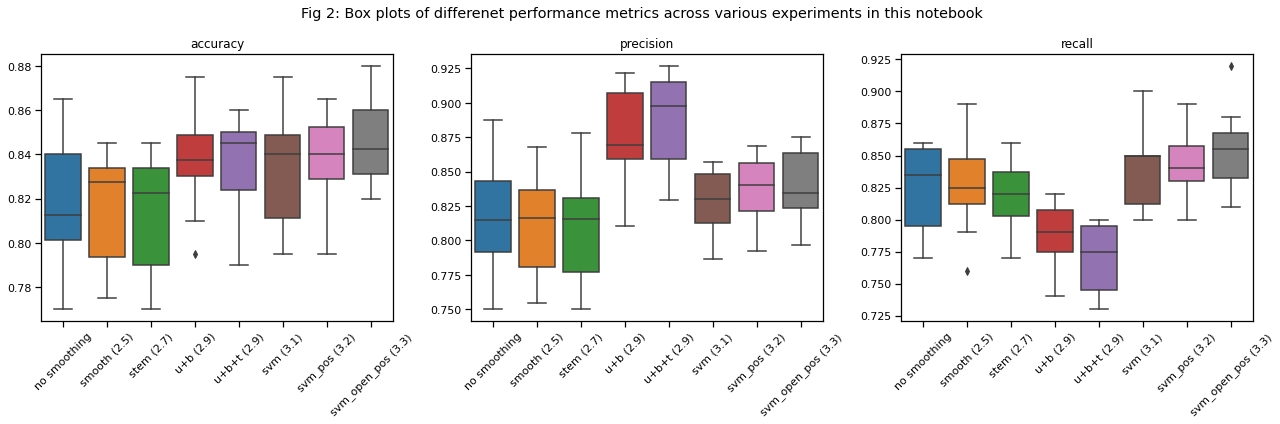

In [53]:
# quick experimentation
sns.set_context("notebook")
metrics_dfs = []
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes = axes.flatten()
for i, metric in enumerate(["accuracy", "precision", "recall"]):
    metric_df = pd.DataFrame(
        data=np.array(
            [
                non_smooth_metrics[i],
                smooth_metrics[i],
                stem_metrics[i],
                bigram_metrics[i],
                trigram_metrics[i],
                svm_metrics[i],
                svm_pos_metrics[i],
                svm_open_pos_metrics[i],
            ]
        ).T,
        columns=[
            "no smoothing",
            "smooth (2.5)",
            "stem (2.7)",
            "u+b (2.9)",
            "u+b+t (2.9)",
            "svm (3.1)",
            "svm_pos (3.2)",
            "svm_open_pos (3.3)",
        ],
    )
    metrics_dfs.append(metric_df)
    ax = axes[i]
    sns.boxplot(data=metric_df, ax=ax)
    ax.tick_params(axis="x", rotation=45)
    ax.set_title(f"{metric}")
fig.suptitle(
    "Fig 2: Box plots of differenet performance metrics across various experiments in this notebook"
)
fig.set_tight_layout(True)
plt.show()

---

- features
    - occurrence
        - information encoded
            - something
                - why important
        - limitations
            - difficult to deal with unseen words
    - POS tag
        - information encoded
            - something
                - why important
        - limitations
- techniques
    - Lexicon
        - limitations
           - requires a lexicon
           - not very performant
    - NB
        - limitations
            - context is lost unless using ngrams
    - disambiguation via 
        - POS tags
            - sometimes not enough (provide example(s))
        - context provided by ngrams
            - feature size explodes
            - sometimes not enough (provide example(s))
    - evaluation via accuracy metric
        - limitations
            - unbalanced datasets
            - evaluation depends on task
                - precision and recall mention

---

# Submission 


In [47]:
# Write your names and student numbers here:
# Giulio Starace # 13010840
# Student 2 #12345

**That's it!**

- Check if you answered all questions fully and correctly. 
- Download your completed notebook using `File -> Download .ipynb` 
- Check if your answers are all included in the file you submit.
- Submit your .ipynb file via *Canvas*. One submission per group. 